In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

ImportError: No module named 'cs231n'

### 加载数据集

In [3]:
# 加载数据集
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 打印数据集大小
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

NameError: name 'load_CIFAR10' is not defined

### 绘制样图

In [2]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)  # 输出所有非0值的下标
    idxs = np.random.choice(idxs, samples_per_class, replace=False) # 输出随机的k个值
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


NameError: name 'y_train' is not defined

### 选取子集并将数据转换为二维

In [11]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


### 创建knn分类器对象

记住 kNN 分类器不进行操作，只是将训练数据进行了简单的存储

In [12]:
from cs231n.classifiers import KNearestNeighbor
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)   # 也就是保存X,y

现在我们可以使用kNN分类器对测试数据进行分类了。我们可以将测试过程分为以下两步：


- 首先，我们需要计算测试样本到所有训练样本的距离。
- 得到距离矩阵后，找出离测试样本最近的k个训练样本，选择出现次数最多的类别作为测试样本的类别


让我们从计算距离矩阵开始。如果训练样本有Ntr个，测试样本有Nte个，则距离矩阵应该是个　Nte×NtrNte×Ntr　大小的矩阵，其中元素[i,j]表示第i个测试样本到第j个训练样本的距离。

下面，打开cs231n/classifiers/k_nearest_neighbor.py，并补全 compute_distances_two_loops 方法，它使用了一个两层循环的方式（非常低效）计算测试样本与训练样本的距离．


#### 修改k_nearest_neighbor.py
#### compute_distances_two_loops 方法

In [14]:
def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
        for j in range(num_train):
            #####################################################################
            # TODO:                                                             #
            # Compute the l2 distance between the ith test point and the jth    #
            # training point, and store the result in dists[i, j]. You should   #
            # not use a loop over dimension, nor use np.linalg.norm().          #
            #####################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            dists[i][j] = np.sqrt(np.sum(np.square(self.X_train[j,:] - X[i,:])))
            # pass

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return dists

(500, 5000)


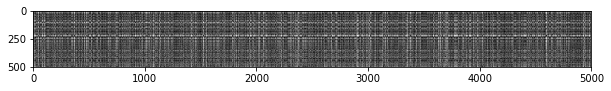

In [17]:
# 测试结果
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

# 可视化结果
plt.imshow(dists, interpolation='none')
plt.show()

随堂测试 /#1: 图中可以明显看出，有一些行或者列明显颜色较浅。（其中深色表示距离小，而浅色表示距离大） 
什么原因导致图中某些行的颜色明显偏浅？ 
为什么某些列的颜色明显偏浅？

回答： 
某些行颜色偏浅，表示测试样本与训练集中的所有样本差异较大，该测试样本可能明显过亮或过暗或者有色差。 
某些列颜色偏浅，所有测试样本与该列表示的训练样本距离都较大，该训练样本可能明显过亮或过暗或者有色差。

### 实现predict_labels方法
#### k_nearest_neighbor.py

In [ ]:
def predict_labels(self, dists, k=1):
    """
    通过距离矩阵，预测每一个测试样本的类别

    输入：
    - dists: 一个(num_test, num_train) 大小的numpy数组，其中dists[i, j]表示
      第i个测试样本到第j个训练样本的距离

    返回：
    - y: 一个 (num_test,)大小的numpy数组，其中y[i]表示测试样本X[i]的预测结果
    """

    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in xrange(num_test):
      # 一个长度为k的list数组，其中保存着第i个测试样本的k个最近邻的类别标签
        closest_y = []
      #########################################################################
      # 任务:                                                                 #
      # 通过距离矩阵找到第i个测试样本的k个最近邻,然后在self.y_train中找到这些 #
      # 最近邻对应的类别标签，并将这些类别标签保存到closest_y中。             #
      # 提示: 可以尝试使用numpy.argsort方法                                   #
      #########################################################################

        closest_y = self.y_train[np.argsort(dists[i])[:k]]

      #########################################################################
      # 任务:                                                                 #
      # 现在你已经找到了k个最近邻对应的标签, 下面就需要找到其中出现最多的那个   #
      # 类别标签，然后保存到y_pred[i]中。如果有票数相同的类别，则选择编号小   #
      # 的类别                                                                #
      #########################################################################

        y_pred[i] = np.argmax(np.bincount(closest_y))

      #########################################################################
      #                           END OF YOUR CODE                            # 
      #########################################################################

    return y_pred

In [18]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [19]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


#### 现在我们将距离计算的效率提升一下，使用单层循环结构的计算方法。
#### 实现compute_distances_one_loop方法
#### k_nearest_neighbor.py

In [25]:
dists_one = classifier.compute_distances_one_loop(X_test)

为了保证向量化的代码运行正确，我们将运行结果与前面的方法的结果进行对比。对比两个矩阵是否相等的方法有很多，比较简单的一种是使用Frobenius范数。Frobenius范数表示的是两个矩阵所有元素的差值的均方根。或者说是将两个矩阵reshape成向量后，它们之间的欧氏距离．

In [26]:
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


#### 完成完全向量化方式运行的compute_distances_no_loops方法
#### k_nearest_neighbor.py

In [32]:
dists_two = classifier.compute_distances_no_loops(X_test)

(500, 1)
(5000,)


In [33]:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


### 下面我们对比一下各方法的执行速度

In [34]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)
 #理论上可以看到，完全矢量化的代码运行效率有明显的提高

Two loop version took 65.263848 seconds
One loop version took 117.102321 seconds
(500, 1)
(5000,)
No loop version took 0.458239 seconds


### 交叉验证
之前我们已经完成了k-Nearest分类器的编写，但是对于k值的选择很随意。下面我们将使用交叉验证的方法选择最优的超参数k。

In [38]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
X_train_folds = np.array_split(X_train, num_folds)
print(len(X_train_folds))
print(X_train_folds[0].shape)
y_train_folds = np.array_split(y_train, num_folds)
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
classifier = KNearestNeighbor()
for k in k_choices:
    accuracies = np.zeros(num_folds)
    for fold in range(num_folds):
        temp_X = X_train_folds[:]
        temp_y = y_train_folds[:]
        X_validate_fold = temp_X.pop(fold)
        y_validate_fold = temp_y.pop(fold)

        temp_X = np.array([y for x in temp_X for y in x])
        temp_y = np.array([y for x in temp_y for y in x])
        classifier.train(temp_X, temp_y)

        y_test_pred = classifier.predict(X_validate_fold, k=k)
        num_correct = np.sum(y_test_pred == y_validate_fold)
        accuracy = float(num_correct) / num_test
        accuracies[fold] =accuracy
    k_to_accuracies[k] = accuracies
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

5
(1000, 3072)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
(1000, 1)
(4000,)
k = 1, accuracy = 0.526000
k = 1, accuracy = 0.514000
k = 1, accuracy = 0.528000
k = 

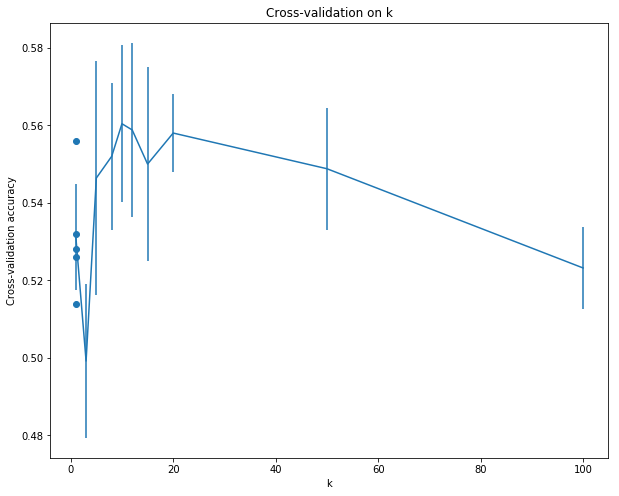

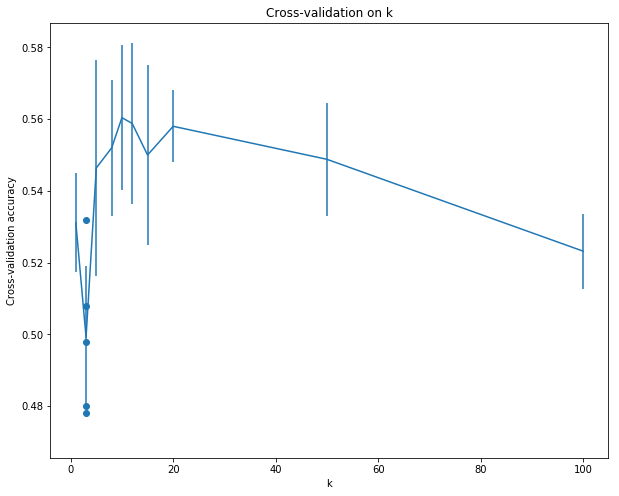

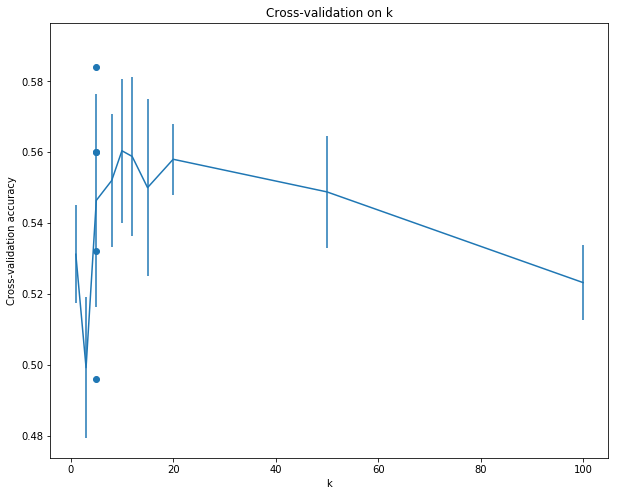

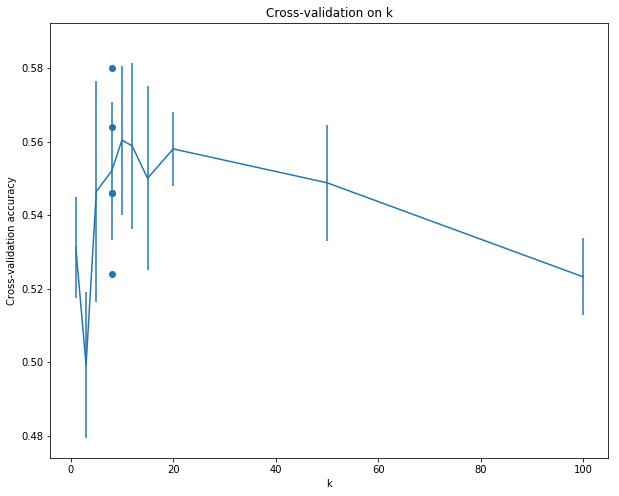

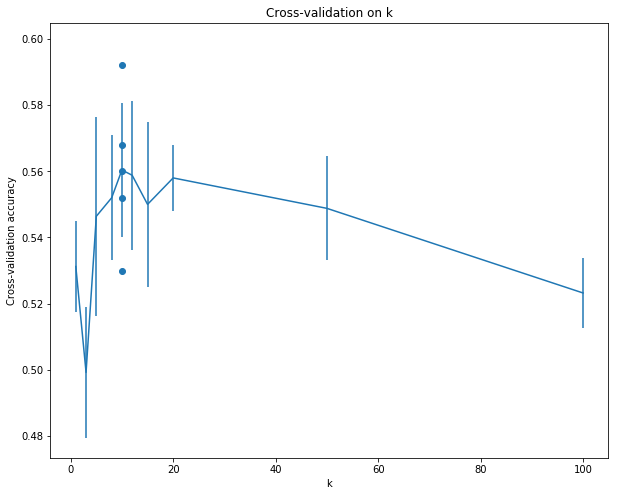

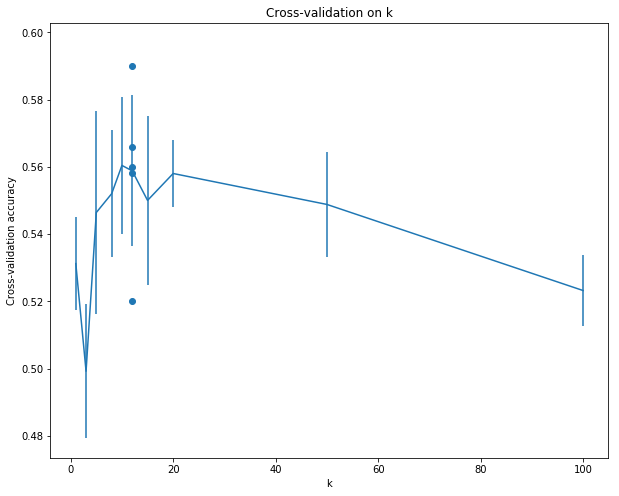

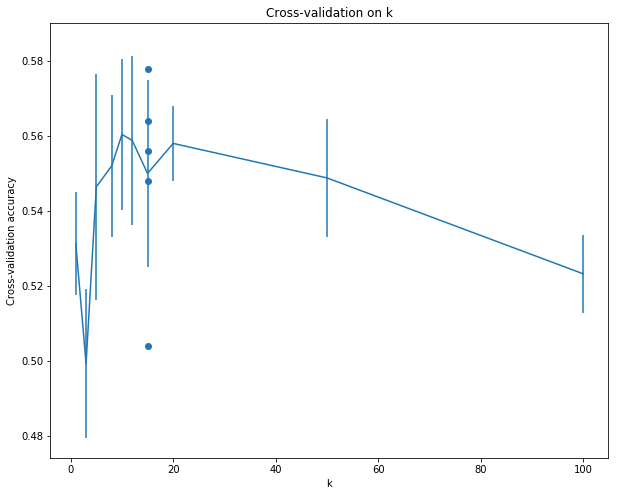

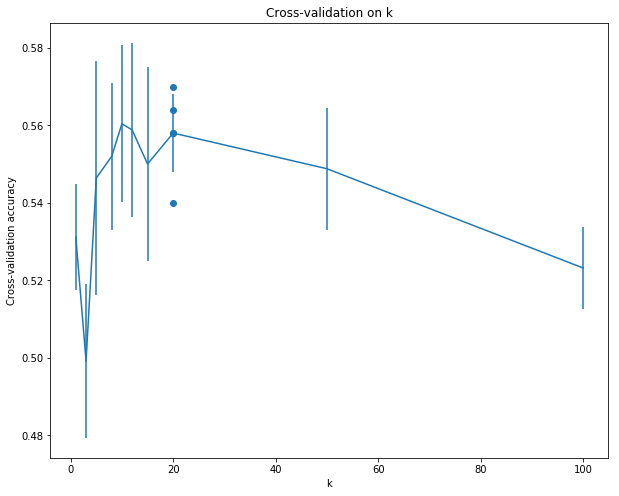

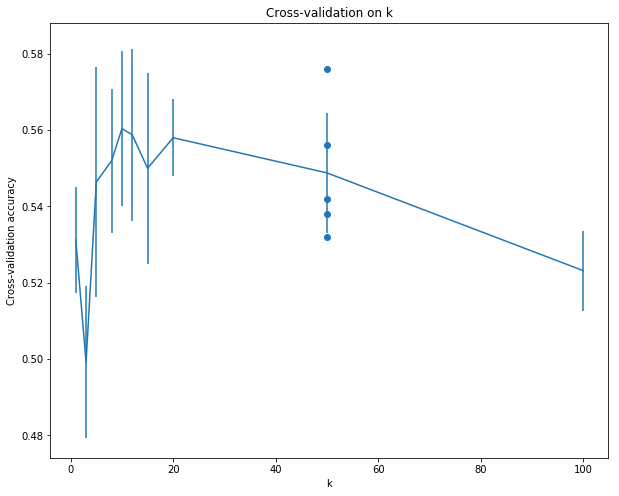

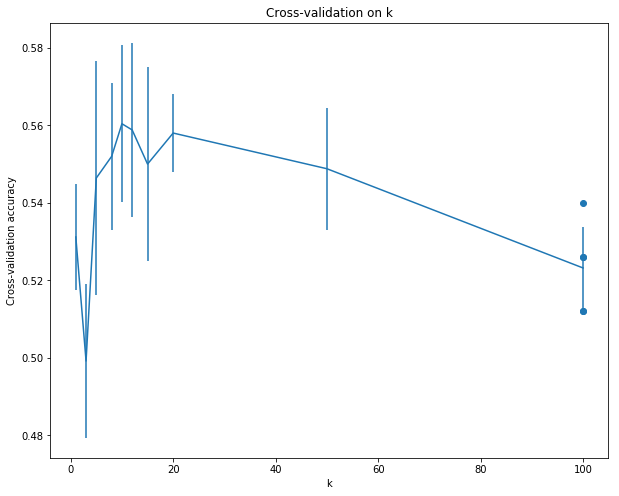

In [39]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

    # plot the trend line with error bars that correspond to standard deviation
    # 画出在不同k值下，误差均值和标准差
    accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
    accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
    plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
    plt.title('Cross-validation on k')
    plt.xlabel('k')
    plt.ylabel('Cross-validation accuracy')
    plt.show()

In [40]:
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# 计算并显示准确率
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
